In [1]:
#<img src="Figs/GEOS_logo.pdf" width="500"/>

# Statistical testing tools for synthetic data sets: 
## <font color=blue>"stat_synthetic.ipynb"</font>
#### Feb 10, 2022  <font color=red>(v. testing)</font>
##### Jeonghyeop Kim (jeonghyeop.kim@gmail.com)

1. This code is a part of the joint inversion project (project4: joint inversion of GNSS and InSAR)

2. The followings will be plotted and saved:
- The "L-curve"
- The "heat map" as a function of relative weighting values
- The misfit of 3-D motion as a function of damping parameters

**`Note that a "true" 3-D field is only available for synthetic data sets`**


In [2]:
## Import libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [3]:
## Initialization

inversion_type='L2'  #'L1' or 'L2'
subdir_name = 'input_files' # sub directory where your input files are



cwd = os.getcwd()
path=os.path.join(cwd, subdir_name)

print("You want statistical test results for the %s inversion results." %inversion_type)
print("You saved %s_stat* & %s_model_coef* files in the following directory:" %(inversion_type,inversion_type))
print("'%s'" %path)

You want statistical test results for the L2 inversion results.
You saved L2_stat* & L2_model_coef* files in the following directory:
'/Users/jkim/main/Joint_GNSS_INSAR/statistical_testing_tools_02092022/input_files'


In [4]:
## Define ComputeModelNorm function

def ComputeModelNorm(model_arr,inversion='L2'):
    if inversion=='L2':
        norm_type=2
    else:
        norm_type=1   
    model_norm=np.linalg.norm(model_arr,norm_type)
    
    return model_norm

In [5]:
## Define MakeFileName function 

def MakeFileName(head,ext,paramList):
    
    glue = '_'
    paramList_glue = glue.join(paramList)
    filename = head + paramList_glue + ext
    
    return filename

In [6]:
## Save parameter variables from the existing files
## wI : weighting for InSAR
## wG : weighting for GNSS
## alpha : regularization param 
## beta  : 2nd regularization param (for L2 only)

load_params = []
scan_file = inversion_type+'_stat_'

if inversion_type=='L2':
    names=['wI','wG','alpha','beta']     
    with os.scandir(path) as it: #scan the directory
        for entry in it:
            if entry.name.startswith(scan_file) and entry.is_file():
                element1=entry.name.split("_")[2:][0]
                element2=entry.name.split("_")[2:][1]
                element3=entry.name.split("_")[2:][2]
                element4=entry.name.split("_")[2:][-1][0:-4] 
                # [0:-4] means without extension (e.g., .dat or .txt)
                list_elements = [element1, element2, element3, element4]
                load_params.append(list_elements)

elif inversion_type=='L1':
    names=['wI','wG','alpha']
    with os.scandir(path) as it: #scan the directory
        for entry in it:
            if entry.name.startswith(scan_file) and entry.is_file():
                element1=entry.name.split("_")[2:][0]
                element2=entry.name.split("_")[2:][1]
                element3=entry.name.split("_")[2:][-1][0:-4]
                # [0:-4] means without extension(e.g., .dat or .txt)
                list_elements = [element1, element2, element3]
                load_params.append(list_elements)        

else: #stop the code
    print(" ********************************************** ")
    print(" *                                            * ")
    print(" * inversion_type must be either 'L2' or 'L1' * ")    
    print(" *                                            * ")    
    print(" ********************************************** ")

    exit() 
    
    
df_param_string = pd.DataFrame(load_params,columns=names)
df_param_numeric = df_param_string.astype(float)

In [7]:
model_norms = []
misfits = []

for i in range(len(df_param_string)):
    paramList=df_param_string.iloc[i,:].values
    
    ## Calculate & save model norms
    head = inversion_type + '_model_coef_'
    ext = '.dat'
    filename_model=MakeFileName(head,ext,paramList)
    model_arr = np.loadtxt(path+'/'+filename_model)
    model_norm=ComputeModelNorm(model_arr,inversion=inversion_type)
    model_norms.append(model_norm)
    
    ## Save inversion misfits
    head = inversion_type + '_stat_'
    ext = '.txt'
    filename_stat=MakeFileName(head,ext,paramList)
    stat_arr = np.loadtxt(path+'/'+filename_stat)
    misfits.append(float(stat_arr))

In [8]:
df_param_numeric['model_norm']=model_norms
df_param_numeric['model_misfit']=misfits

#fixed wI, wG, beta -> vary alpha -> save norm and misfit -> L curve.
#fixed alpha and beta -> vary wl, wG -> save misfit -> heat map.

In [37]:
df_param_numeric.shape

(9216, 6)

In [38]:
pd.set_option('display.max_rows', 10)

In [11]:
df_param_numeric_sorted=df_param_numeric.sort_values(by=['wI', 'wG', 'beta', 'alpha'],ignore_index=True)
#df_param_numeric_group=df_param_numeric_sorted.groupby(['wI', 'wG', 'beta'])


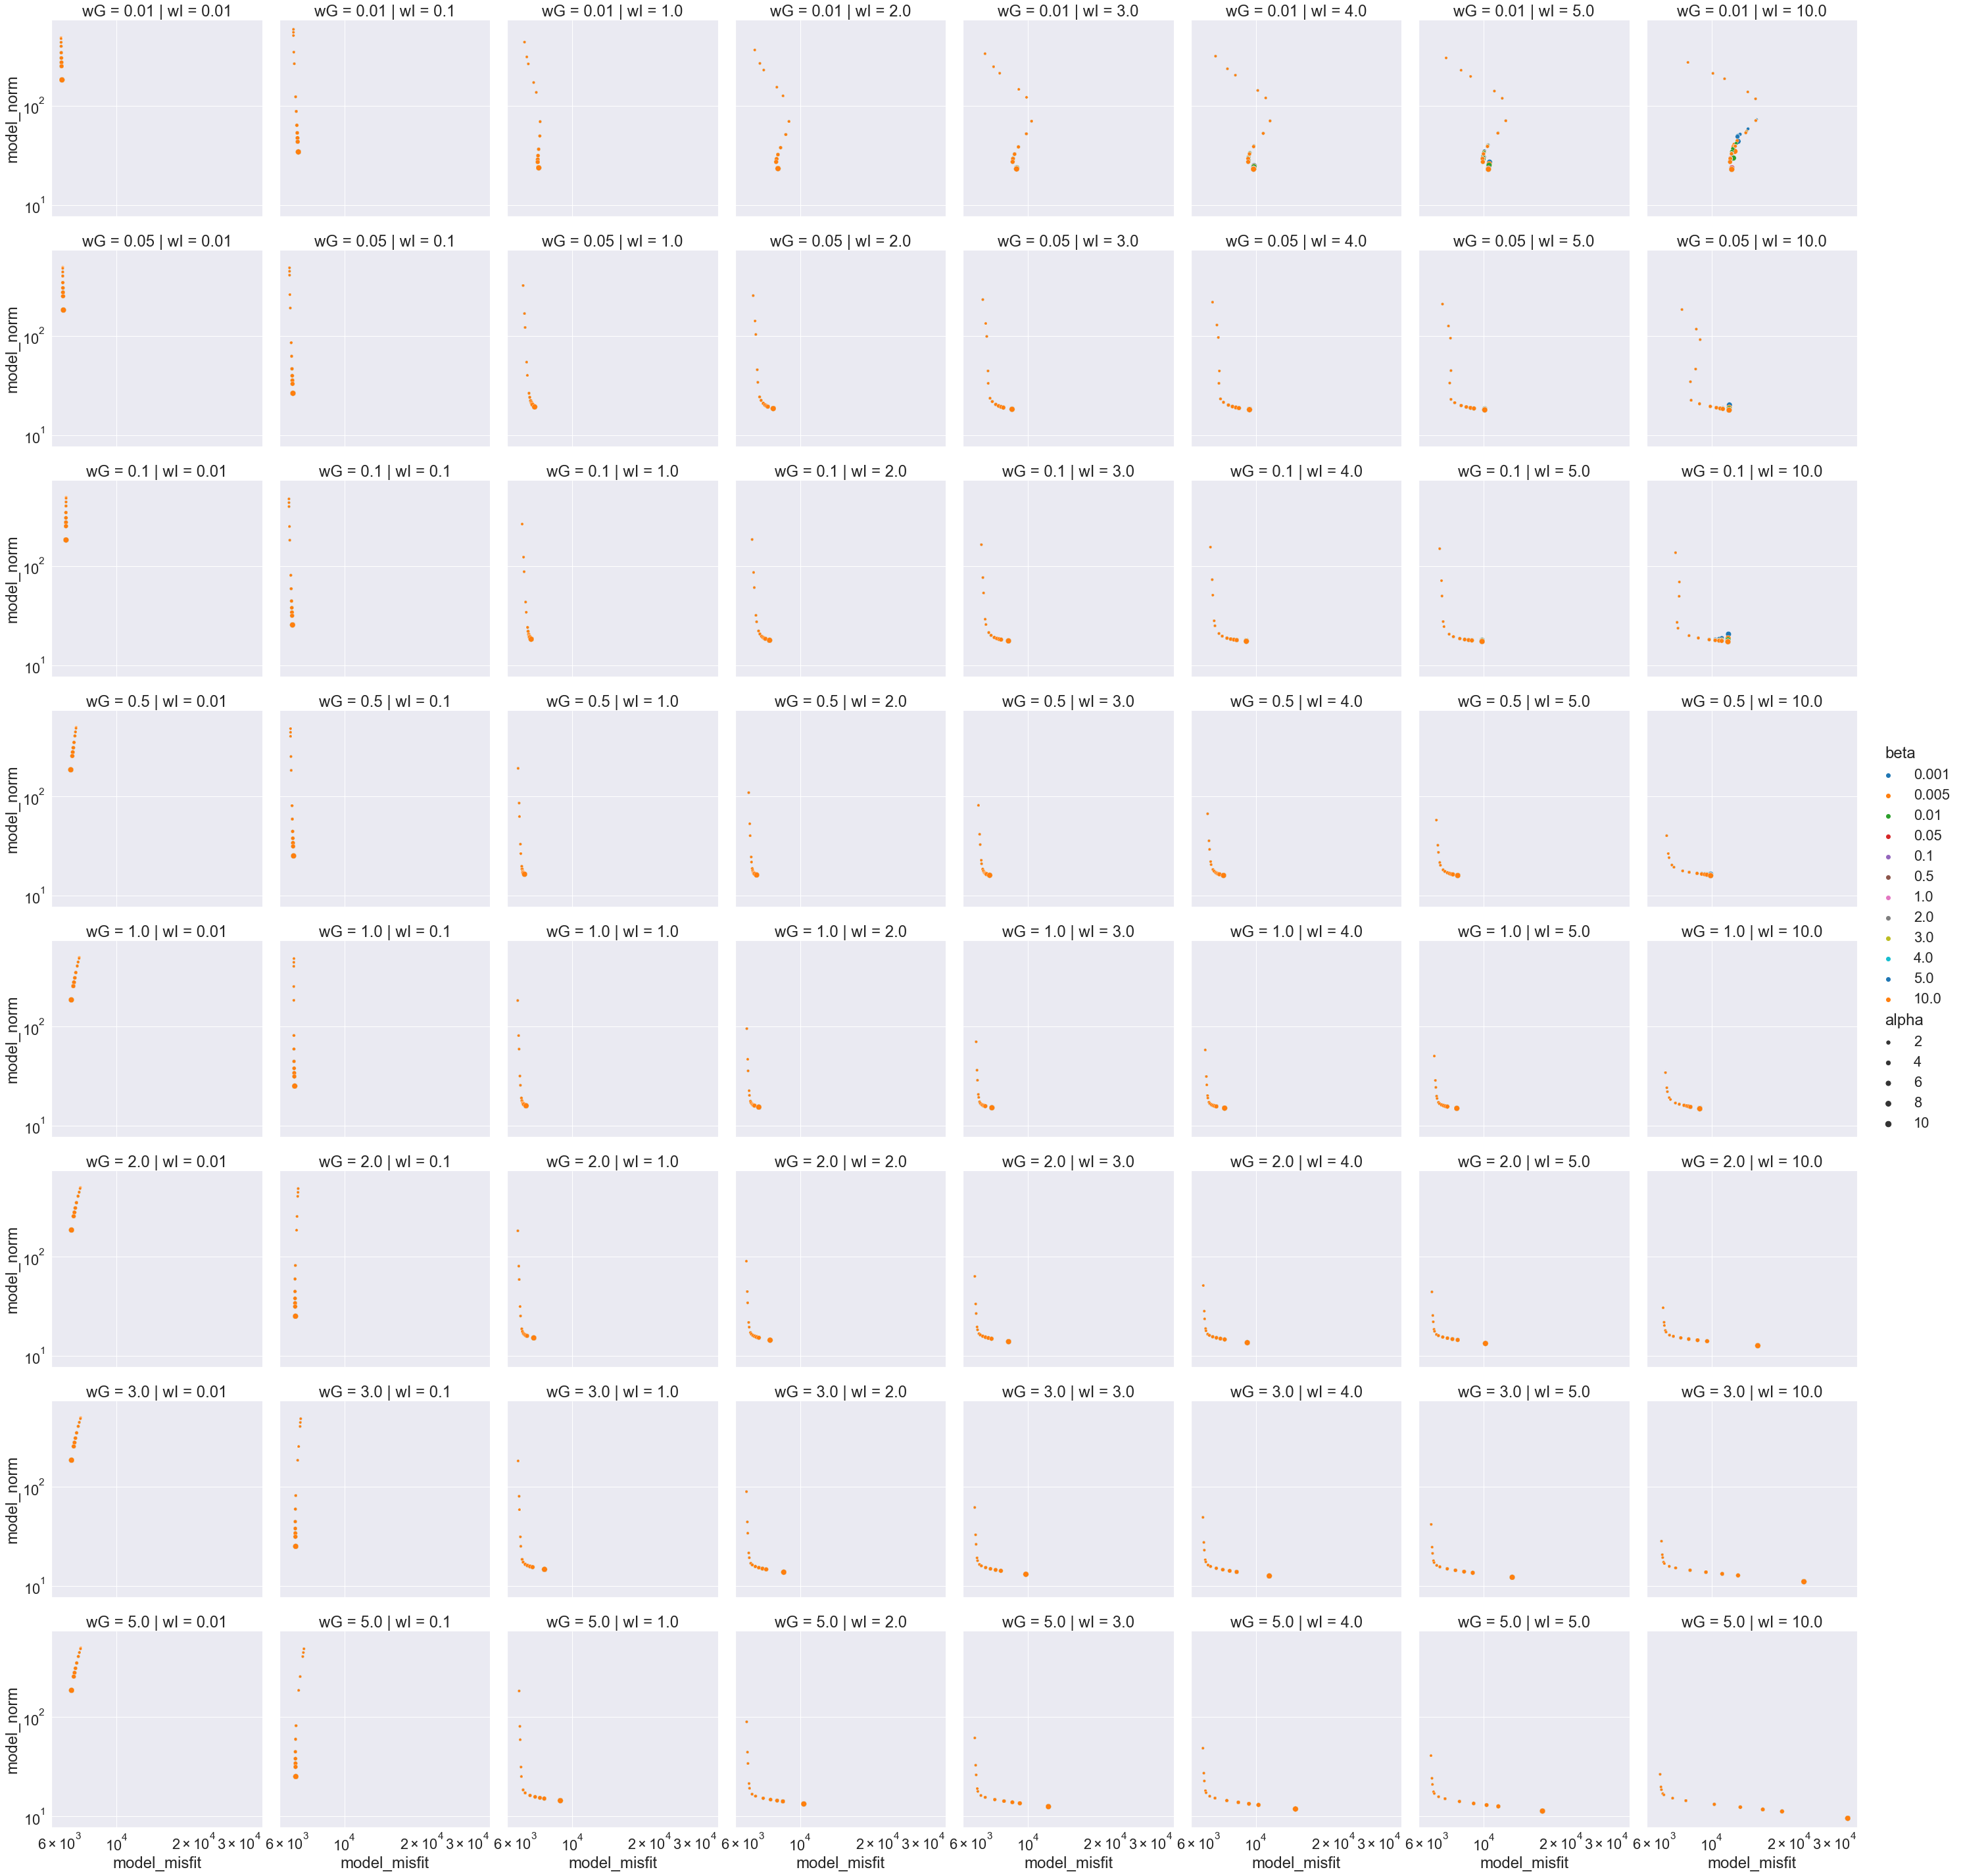

In [20]:
#viz_dict={'axes.facecolor':'cornflowerblue', 'figure.facecolor':'cornflowerblue', 'axes.titlesize':18, 'axes.labelsize':32}
#sns.set_style("ticks")
#sns.set_style("darkgrid")
#sns.set_theme(font_scale=2, rc=viz_dict)
#matplotlib.rc_file_defaults()


viz_dict={'axes.facecolor':'white', 'figure.facecolor':'white', 'axes.titlesize':18, 'axes.labelsize':32}

sns.set_theme(font_scale=2)

sns.relplot( y="model_norm", x="model_misfit", hue="beta", size="alpha",  
             data=df_param_numeric_sorted, col="wI", row="wG", palette= "tab10")
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.show()
#plt.savefig("L-curve.pdf")

In [13]:
df_param_numeric_sorted=df_param_numeric.sort_values(by=['wI', 'wG', 'beta', 'alpha'],ignore_index=True)
df_param_numeric_sorted

,wI,wG,alpha,beta,model_norm,model_misfit
0,0.01,0.01,0.001,0.001,487.535420,6092.571151
1,0.01,0.01,0.005,0.001,487.073827,6092.571286
2,0.01,0.01,0.010,0.001,486.498598,6092.571706
3,0.01,0.01,0.050,0.001,481.962480,6092.584833
4,0.01,0.01,0.100,0.001,476.452544,6092.624345
5,0.01,0.01,0.500,0.001,437.777342,6093.648272
6,0.01,0.01,1.000,0.001,399.522767,6096.006332
7,0.01,0.01,2.000,0.001,343.683215,6102.045796
8,0.01,0.01,3.000,0.001,304.246769,6108.341969
9,0.01,0.01,4.000,0.001,274.590802,6114.298158


In [22]:
df_param_numeric_sorted2=df_param_numeric.sort_values(by=['beta', 'alpha', 'wI', 'wG'],ignore_index=True)

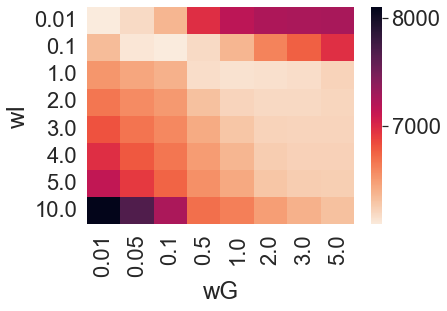

In [70]:
a=df_param_numeric_sorted2.iloc[0:64,[0,1,5]]
#ax = sns.heatmap(a)

flights = a.pivot("wI", "wG", "model_misfit")
ax = sns.heatmap(flights,cmap="rocket_r")


In [60]:
X=a.iloc[:,0].values.reshape(8,8)
Y=a.iloc[:,1].values.reshape(8,8)
Z=a.iloc[:,2].values.reshape(8,8)


/var/folders/jq/ypdzxq_53jxgwqt1xzdl8hb40000gn/T/ipykernel_67721/3192281681.py:1: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(X,Y,Z, cmap='RdBu_r')


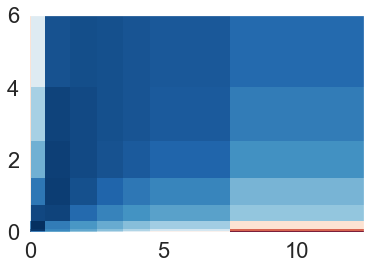

In [67]:
plt.pcolormesh(X,Y,Z, cmap='RdBu_r')


In [14]:
df_wl = df_param_numeric.wI
df_wl.shape
df_wl_unique = pd.unique(df_wl)

df_wG = df_param_numeric.wG
df_wG.shape
df_wG_unique = pd.unique(df_wG)

df_beta = df_param_numeric.beta
df_beta.shape
df_beta_unique = pd.unique(df_beta)

df_alpha = df_param_numeric.alpha
df_alpha.shape
df_alpha_unique = pd.unique(df_alpha)

In [15]:
# ## Obtain norms of the column vectors in the G matrix
# df_G=pd.read_csv(path+'/'+'G_matrix.out')
# n_col=df_G.shape[1]
# df_G.columns=[i for i in range(n_col)]
# G = df_G.to_numpy()

# amp_column=np.linalg.norm(G,axis=0) #column vectors' magnitudes

# ##normalized_model = norm_column * model

In [16]:
#df = df.drop_duplicates(subset=['0'],keep=False)